# In this assignment we learn how to derive a neural network emultor based on the cosmopower emulator (Mancini et al. 2021). Based on this emualtor we perform a PCA data compression.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install cosmopower

### For this assignment you need the install cosmopower yourself https://github.com/alessiospuriomancini/cosmopower or you just use the cosmopower_NN.py module that is provided. However in the latter case you need to install tensorflow: https://www.tensorflow.org/install

In [3]:
import matplotlib.pyplot as plt
import random
import numpy as np
from numpy.linalg import inv
import cosmopower as cp
from cosmopower import cosmopower_NN
import tensorflow as tf
import keras

## Preparation: load in the all the 10000 model vectors and corresponding paramters that we use to bulit the emulator.

In [4]:
models = np.load('drive/MyDrive/Colab Notebooks/data_4_assignment2/models.npy')
parameters = np.load('drive/MyDrive/Colab Notebooks/data_4_assignment2/parameters.npz')

#### Divide the models and parameters in a training and test set.

In [5]:
train_sample = np.arange(8000) # select which elements you wanna use for training
test_sample = np.arange(8000,10000) # select which elements you wanna use for training

train_params = {}
for name in parameters.keys():
    train_params[name]=list(np.array(parameters[name])[train_sample])

test_params = {}
for name in parameters.keys():
    test_params[name]=list(np.array(parameters[name])[test_sample])

train_features = models[train_sample]
test_features = models[test_sample]

#### Train the emulator. Reasonable hyper parameres are set already, but test out other settings and comment on what you observe regarding accuracy and speed.

In [6]:
#Min-Max regularization: improves accuracy, more stable training
min = np.min(train_features, axis=0)
max = np.max(train_features-min, axis=0)
features_modified = (train_features-min)/(max)

In [7]:
cp_nn = cosmopower_NN(parameters=list(parameters.keys()),
                    modes=np.linspace(-1,1,train_features.shape[1]),
                    n_hidden = [512, 512, 512, 512], # This you should modify. In this exmaple we use three layers with 4, 5 and 6 nodes. Is this enough?
                    verbose=True, # useful to understand the different steps in initialisation and training
                    )

device = 'gpu'
with tf.device(device):
  cp_nn.train(training_parameters=train_params,
              training_features=features_modified,
              filename_saved_model='drive/MyDrive/Colab Notebooks/data_4_assignment2/emulator_test', # the name of the emulator and where to save it
              # cooling schedule
              validation_split=0.1, # The precentage from train sample that is used for the validation
              learning_rates=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6], # the different leanring rates. This need to be adjusted
              batch_sizes=[700,700,700,700,700], # the number for models that are used to adjust the NN parameters
              gradient_accumulation_steps =[1,1,1,1,1],
              patience_values = [100,100,100,100,100], # Number of epoch to wait before decreasing the learning rate if the loss does not improve anymore
              max_epochs = [1000,1000,1000,1000,1000]) # Maximal number of epoch before decreasing the learning rate


Initialized cosmopower_NN model, 
mapping 4 input parameters to 900 output modes, 
using 4 hidden layers, 
with [512, 512, 512, 512] nodes, respectively. 

Starting cosmopower_NN training, 
using 10 per cent of training samples for validation. 
Performing 5 learning steps, with 
[0.01, 0.001, 0.0001, 1e-05, 1e-06] learning rates 
[700, 700, 700, 700, 700] batch sizes 
[1, 1, 1, 1, 1] gradient accumulation steps 
[100, 100, 100, 100, 100] patience values 
[1000, 1000, 1000, 1000, 1000] max epochs 

learning rate = 0.01, batch size = 700


 39%|███▉      | 388/1000 [17:29<27:35,  2.71s/it, loss=0.00369]


Validation loss = 0.0029383032
Model saved.
Reached max number of epochs. Validation loss = 0.0029383032
Model saved.
learning rate = 0.001, batch size = 700


 18%|█▊        | 180/1000 [08:07<37:00,  2.71s/it, loss=0.000444]


Validation loss = 0.00035991485
Model saved.
Reached max number of epochs. Validation loss = 0.00035991485
Model saved.
learning rate = 0.0001, batch size = 700


100%|██████████| 1000/1000 [43:44<00:00,  2.62s/it, loss=0.00014]


Reached max number of epochs. Validation loss = 0.00012906796
Model saved.
learning rate = 1e-05, batch size = 700


 11%|█         | 106/1000 [04:39<39:13,  2.63s/it, loss=0.000106]


Validation loss = 0.00010404022
Model saved.
Reached max number of epochs. Validation loss = 0.00010404022
Model saved.
learning rate = 1e-06, batch size = 700


 10%|█         | 100/1000 [04:28<40:12,  2.68s/it, loss=0.000115]

Validation loss = 0.00011367263
Model saved.
Reached max number of epochs. Validation loss = 0.00011367263
Model saved.


Model's hyperparameters
- I splitted the dataset in 80% training data and 20% for testing. The validation split is set to 10%.
- The learning rate range i choose was the one delivering the best performace. (comment on e-5 vs e-6 once you have results)
- Number of nodes: the optimal number of nodes seems to be in the order of magnitude $\approx 100$. I choose to use 512 since it's the value that was used in the cosmopower paper. Increasing the number of nodes could increase the accuracy, but I don't have more GPU time on colab :(
- Number of layers: I used four layers because the loss function is able becomes one full order of magnitude lower than the case with three layers only.
- For the 4 layers network I used a batchsize of 1000 as incresing the batch size decreases the computational time, making the computation feasible on cpus. I also tested a network with only 3 layers but a smaller batchsize, but this network turned out to be less accurate.

In conclusion, 4 layers seem to be necessary in order to obtain the best performance. On the other hand, the batchsize doesn't have as much of an impact on the loss function. The learning rate is another very important parameter: I obtained the best accuarcy when the learning rate is decreased from $10^{-2}$ to $10^{-6}$.

#### Check the accuracy of the emulator, by computing how many predictions are inside 68%, 95%, 99%.

In [9]:
cp_nn = cosmopower_NN(restore=True,
                      restore_filename='drive/MyDrive/Colab Notebooks/data_4_assignment2/emulator_test',
                      )

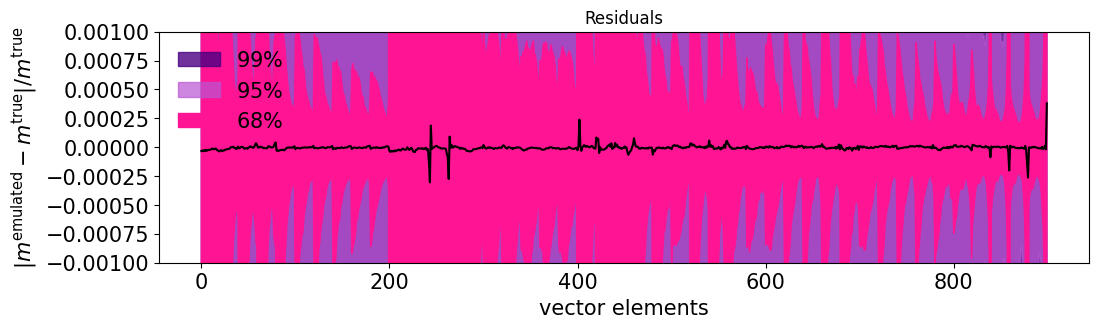

In [10]:
emulated_features = cp_nn.predictions_np(test_params)*max + min
# if you modified the training features you need to convert back the output back the original data vectors

diff=(emulated_features/test_features-1) # Measure the relative difference between test sample and the emualted models

mean_diff = np.median(diff, axis=0)

percentiles1 = np.percentile(diff, [0.5, 99.5], axis=0)
percentiles2 = np.percentile(diff, [2.5, 97.5], axis=0)
percentiles3 = np.percentile(diff, [16, 84], axis=0)
bins=range(diff.shape[1])

plt.figure(figsize=(12, 3), dpi=100)
plt.fill_between(bins, percentiles1[0], percentiles1[1], label='$99\%$', alpha=0.8, color="indigo")
plt.fill_between(bins, percentiles2[0], percentiles2[1], label='$95\%$', alpha=0.7, color="mediumorchid")
plt.fill_between(bins, percentiles3[0], percentiles3[1], label='$68\%$', alpha=1, color="deeppink")
plt.plot(bins,mean_diff,'-',color='black')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Residuals")
plt.legend(frameon=False, fontsize=15, loc='best')
plt.ylabel(r'$| m^{\mathrm{emulated}} - m^{\mathrm{true}}|/  m^{\mathrm{true}}$', fontsize=15)
plt.xlabel(r'vector elements',  fontsize=15)
plt.ylim(-0.001,0.001)
#plt.xlim(800,900)
plt.show()

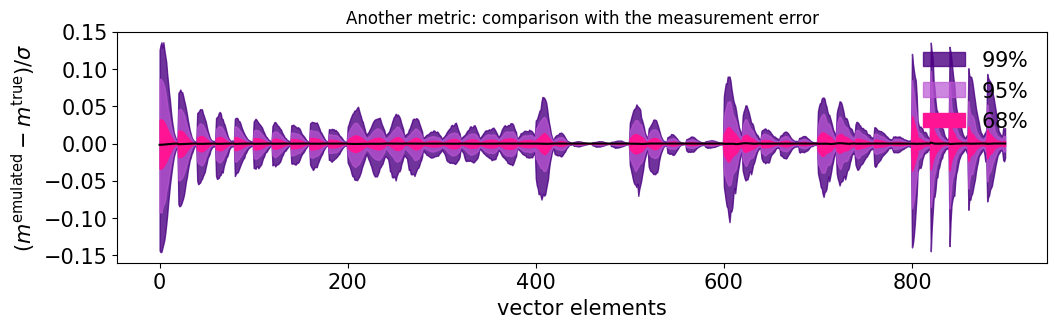

In [11]:
cov=np.load('drive/MyDrive/Colab Notebooks/data_4_assignment1/covariance.npy')

diff = (emulated_features-test_features)/np.sqrt(np.diag(cov)) # Measure the relative difference between test sample and the emualted models

mean_diff = np.mean(diff, axis=0)

percentiles1 = np.percentile(diff, [0.5, 99.5], axis=0)
percentiles2 = np.percentile(diff, [2.5, 97.5], axis=0)
percentiles3 = np.percentile(diff, [16, 84], axis=0)
bins=range(diff.shape[1])

plt.figure(figsize=(12, 3), dpi=100)
plt.fill_between(bins, percentiles1[0], percentiles1[1], label='$99\%$', alpha=0.8, color="indigo")
plt.fill_between(bins, percentiles2[0], percentiles2[1], label='$95\%$', alpha=0.7, color="mediumorchid")
plt.fill_between(bins, percentiles3[0], percentiles3[1], label='$68\%$', alpha=1, color="deeppink")
plt.plot(bins,mean_diff,'-',color='black')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Residuals")
plt.legend(frameon=False, fontsize=15, loc='best')
plt.ylabel(r'$(m^{\mathrm{emulated}} - m^{\mathrm{true}}) /  \sigma$', fontsize=15)
plt.xlabel(r'vector elements',  fontsize=15)
plt.title("Another metric: comparison with the measurement error")
#plt.ylim(-0.001,0.001)
#plt.xlim(800,900)
plt.show()

In order to test the emulator's accuracy I evaluated the residuals and also the ratio $\frac{ m_{emu}- m_{true}}{\sigma}$ . Both metrics show that the emulator is very accurate: the residuals are of the order of magnitude $10^{-4}$ and the emulation error is also orders of magnitude lower than the measurement error.

Compute $\chi^2$ for the test set. $\frac{\chi^2}{k}=(m_t-m_e)^TC^{-1}(m_t-m_e)$

In [12]:
chi_square = np.diag((test_features-emulated_features) @ inv(cov) @ (test_features-emulated_features).T)

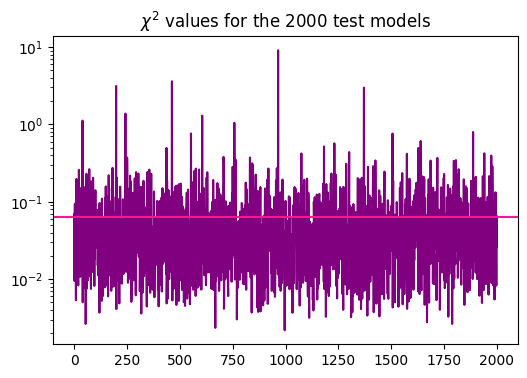

In [13]:
plt.figure(figsize=(6, 4), dpi=100)
plt.plot(np.arange(2000), chi_square, color="purple")
plt.axhline(np.mean(chi_square), color="deeppink")
plt.title(r"$\chi^2$ values for the 2000 test models")
plt.yscale("log")

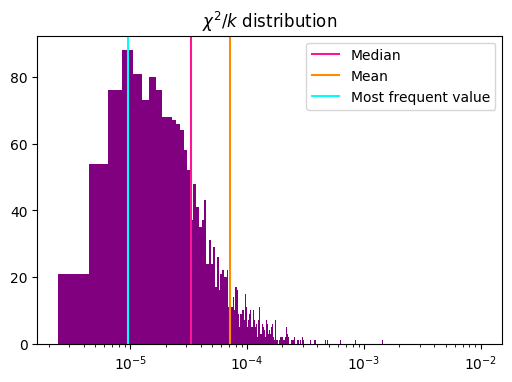

In [14]:
plt.figure(figsize=(6, 4), dpi=100)
nc,bins,_=plt.hist(chi_square/900, bins=5000,color="purple")
plt.axvline(np.median(chi_square/900), color="deeppink", label="Median")
plt.axvline(np.mean(chi_square/900), color="darkorange", label="Mean")
plt.axvline((bins[np.argmax(nc)]+bins[np.argmax(nc)+1])/2., color="cyan", label="Most frequent value")
plt.legend()
plt.xscale("log")
plt.title(r"$\chi^2/k$ distribution")
plt.show()

The values of $\frac{\chi^2}{k}$ for the 2000 test models are very small, the most common value being $\approx 10^{-5}$. This, again, is telling us that the emulator is very accurate.

##### Next we want perform a Fisher Analysis using the emualtor. We want you to compute the covariance of the parameters $\Theta = \{\Omega_\mathrm{m},w\}$, which can be estimated by $C(\Theta) = F^{-1}$, where $$F_{ij}= \left(\frac{\partial m(\Theta)}{\partial \Theta_i}\right)^{T} C^{-1} \left(\frac{\partial m(\Theta)}{\partial \Theta_i}\right)$$
##### For the partial derivatives we use the five point stencil beam given by $$\frac{\partial m(\Theta)}{\partial \Theta_i}\approx \frac{-m(\Theta_i + 2\ \Delta \Theta_i) + 8 \ m(\Theta_i +  \Delta \Theta_i) - 8 \ m(\Theta_i - \Delta \Theta_i) + m(\Theta_i - 2\ \Delta \Theta_i)}{12 \ \Delta \Theta_i }$$

In [16]:
Om_shift = 0.001 #decide for a reasonable stepsize in Omega_m
w_shift = 0.001 #decide for a reasonable stepsize in w

# This example compute the model for two different Omega_m values.
paramters_Om = {'omega_m':[0.3,0.3+Om_shift, 0.3+2.*Om_shift, 0.3-Om_shift,0.3-2.*Om_shift],'w':[np.mean(test_params['w'])]*5,'As':[np.mean(test_params['As'])]*5,'omega_b':[np.mean(test_params['omega_b'])]*5}
paramters_w = {'omega_m':[np.mean(test_params['omega_m'])]*5,'w':[-1,-1+w_shift,-1+2*w_shift, -1-w_shift,-1-2*w_shift],'As':[np.mean(test_params['As'])]*5,'omega_b':[np.mean(test_params['omega_b'])]*5}

features_4_div = cp_nn.predictions_np(paramters_Om)*max + min
features_4_div_w = cp_nn.predictions_np(paramters_w)*max + min

derivative_Om =  (-features_4_div[2,:] + 8* features_4_div[1,:]- 8*features_4_div[3,:] + features_4_div[4,:])/(12*Om_shift) # compute derivative
derivative_w = (-features_4_div_w[2,:] + 8* features_4_div_w[1,:]- 8*features_4_div_w[3,:] + features_4_div_w[4,:])/(12*w_shift) # compute derivative

#### So lets compute the Fisher matrix the corresponding covariance matrix of the paramters:

In [17]:
cov=np.load('drive/MyDrive/Colab Notebooks/data_4_assignment1/covariance.npy')
inv_cov = inv(cov)

FoM_11 = derivative_Om @ inv_cov @ derivative_Om
FoM_22 = derivative_w @ inv_cov @ derivative_w
FoM_12 = derivative_w @ inv_cov @ derivative_Om
FoM_best = np.array([[FoM_11,FoM_12],[FoM_12,FoM_22]])

Cov_parameter = inv(FoM_best)
Cov_parameter = np.sqrt(np.diag(Cov_parameter))

In [18]:
print("sigma_Om = ", Cov_parameter[0])
print("sigma_w = ", Cov_parameter[1])

sigma_Om =  0.0011362484944251326
sigma_w =  0.01677757261222096


#### First you need to generate the transformation from our model/data vectors to the PCA elements based on the 10k models. Then you need transform all 100k noisy data vectors from which you should then measure the covariance on the PCA elements. Now it should get clear why you had to genereate the 100k multvariate Gaussian random variables.

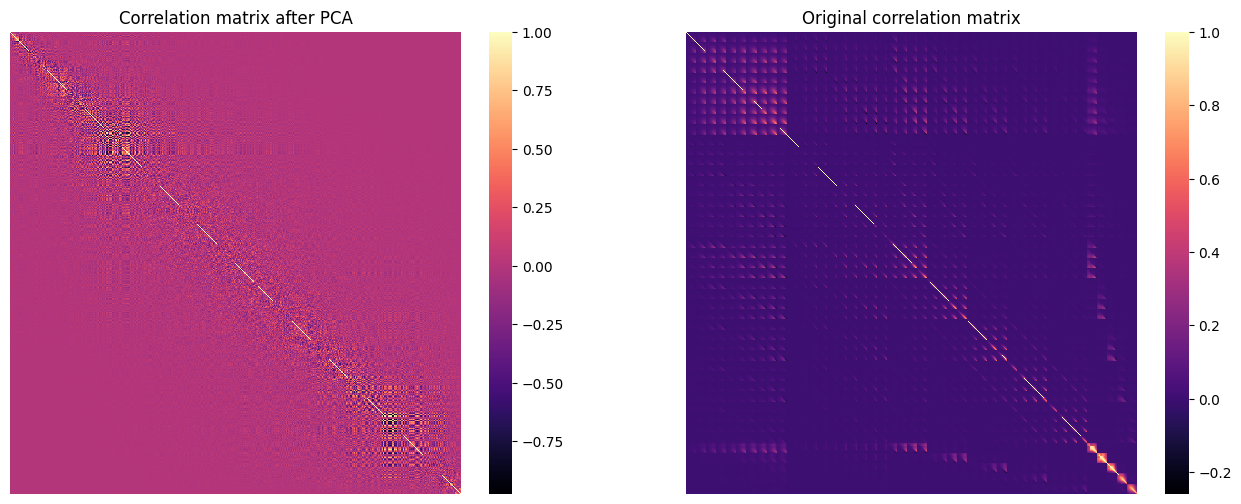

In [19]:
from sklearn.decomposition import PCA
import seaborn as sns

N_pca = 900 # Decide how many PCA eigenvalues you want to use
models = np.load('drive/MyDrive/Colab Notebooks/data_4_assignment2/models.npy')
mean = np.mean(models,axis=0) # for numerical stability you should subtract the mean of each element
pca = PCA(n_components = N_pca, svd_solver='full')
models_pca = pca.fit_transform(models-mean) # Perform the PCA fitting. Now you can use pca for the transformation

#rotate covariance matrix. If you do not how to do that. You can also create 10k random data vectors and tranform each one individual,
# and the compute the covariance matrix from them
rotation_matrix = pca.components_.T
cov_pca = rotation_matrix.T @ cov @ rotation_matrix

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].set_title("Correlation matrix after PCA")
sns.heatmap(cov_pca/np.outer(np.sqrt(np.diag(cov_pca)),np.sqrt(np.diag(cov_pca))), annot=False, cbar=True, cmap="magma", xticklabels=[], yticklabels=[], ax=axs[0])
axs[1].set_title("Original correlation matrix")
sns.heatmap(cov/np.outer(np.sqrt(np.diag(cov)),np.sqrt(np.diag(cov))), annot=False, cbar=True, cmap="magma", xticklabels=[], yticklabels=[], ax=axs[1])
plt.show()

I am rotating the correlation matrix putting it in the basis of principal components. As expected, the matrix appears to be more diagonal since the basis vector are uncorrelated.

#### Increase successively the number of PCA elements from which you compute the Fisher matrix. Convince yourself that if you take all possible PCA elements you converge to same contraining power as for original Fisher analysis. How many PCA elements do you need to have 10% and 1% of the constraining power as the original Fisher analysis?

In [20]:
from tqdm.notebook import tqdm
paramter_constraints = []

for N_pca in tqdm(np.arange(2,900)):

    inv_cov_pca = inv(cov_pca[:N_pca,:N_pca])

    features_4_div_pca = pca.transform((features_4_div-mean))[:,:N_pca]
    features_4_div_pca_w = pca.transform((features_4_div_w-mean))[:,:N_pca]

    derivative_Om_pca =  (-features_4_div_pca[2,:] + 8* features_4_div_pca[1,:]- 8*features_4_div_pca[3,:] + features_4_div_pca[4,:])/(12*Om_shift) # compute derivative
    derivative_w_pca = (-features_4_div_pca_w[2,:] + 8* features_4_div_pca_w[1,:]- 8*features_4_div_pca_w[3,:] + features_4_div_pca_w[4,:])/(12*w_shift)

    FoM_11 = derivative_Om_pca @ inv_cov_pca @ derivative_Om_pca
    FoM_22 = derivative_w_pca @ inv_cov_pca @ derivative_w_pca
    FoM_12 = derivative_w_pca @ inv_cov_pca @ derivative_Om_pca
    FoM_best_pca = np.array([[FoM_11,FoM_12],[FoM_12,FoM_22]])

    Cov_parameter_pca = inv(FoM_best_pca)
    paramter_constraints.append(np.sqrt(np.diag(Cov_parameter_pca)))
paramter_constraints = np.array(paramter_constraints)
np.save("drive/MyDrive/Colab Notebooks/data_4_assignment1/sigma.npy", paramter_constraints)

  0%|          | 0/898 [00:00<?, ?it/s]

In [21]:
paramter_constraints = np.load("drive/MyDrive/Colab Notebooks/data_4_assignment1/sigma.npy")

### Plot the constraints depending on the number of PCA that you have used. How many PCA elements do you need to get 10% and 1% of the maximum constraining power.

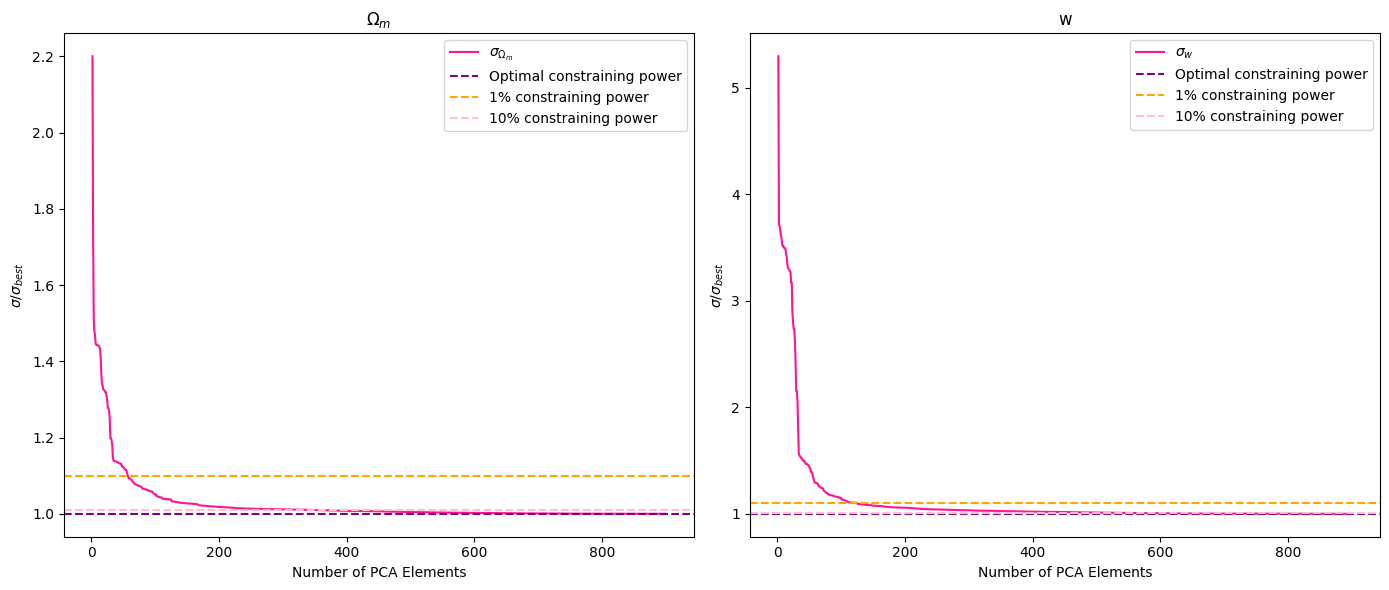

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot Omega_m constraints
axs[0].plot(np.arange(2, 900), paramter_constraints[:, 0]/Cov_parameter[0], color='#FF1493', linestyle='-', label = "$\sigma_{\Omega_m}$")
axs[0].set_xlabel('Number of PCA Elements')
axs[0].set_ylabel(r'$\sigma/\sigma_{best}$')
axs[0].set_title(r'$\Omega_m$')
axs[0].axhline(1, color='#800080', linestyle='--', label="Optimal constraining power")
axs[0].axhline(1.1, color='orange', linestyle='--', label="1% constraining power")
axs[0].axhline(1.01, color='pink', linestyle='--', label="10% constraining power")
axs[0].legend()

# Plot w constraints
axs[1].plot(np.arange(2, 900), paramter_constraints[:, 1]/Cov_parameter[1], color='#FF1493', linestyle='-', label = "$\sigma_{w}$")
axs[1].set_xlabel('Number of PCA Elements')
axs[1].set_ylabel(r'$\sigma/\sigma_{best}$')
axs[1].set_title('w')
axs[1].axhline(1, color='#800080', linestyle='--', label="Optimal constraining power")
axs[1].axhline(1.1, color='orange', linestyle='--', label="1% constraining power")
axs[1].axhline(1.01, color='pink', linestyle='--', label="10% constraining power")
axs[1].legend()

plt.tight_layout()
plt.show()

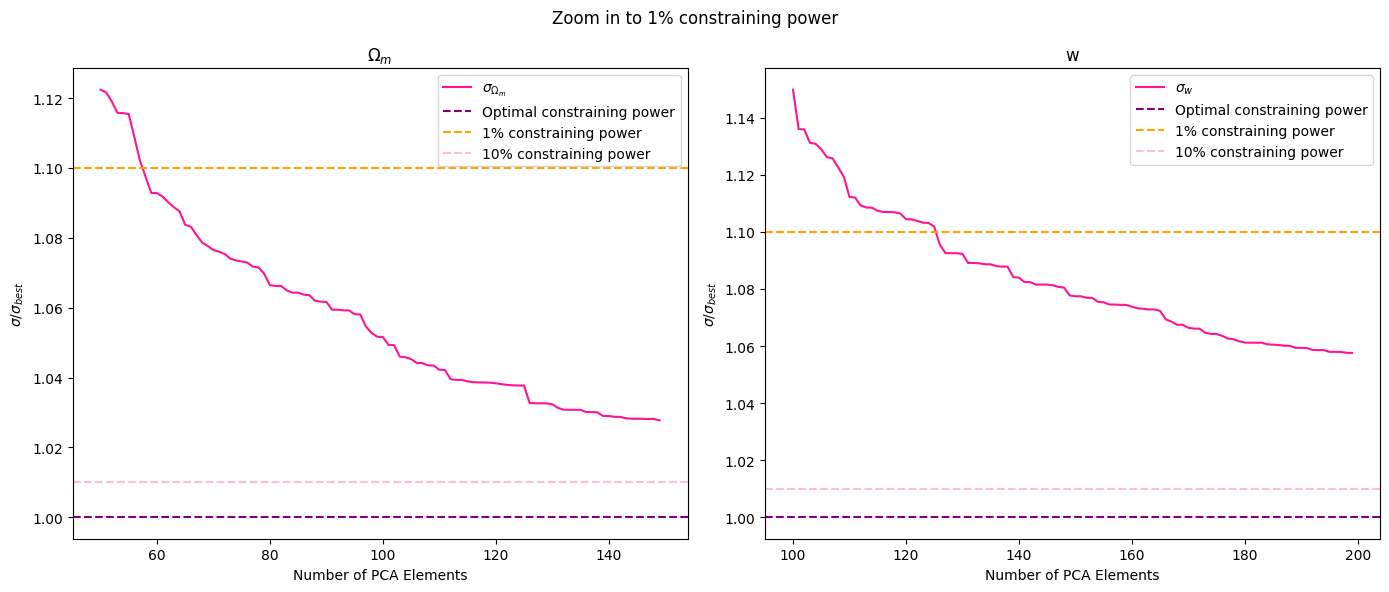

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Zoom in to 1% constraining power")

# Plot Omega_m constraints
axs[0].plot(np.arange(50, 150), paramter_constraints[48:148, 0]/Cov_parameter[0], color='#FF1493', linestyle='-', label = "$\sigma_{\Omega_m}$")
axs[0].set_xlabel('Number of PCA Elements')
axs[0].set_ylabel(r'$\sigma/\sigma_{best}$')
axs[0].set_title(r'$\Omega_m$')
axs[0].axhline(1, color='#800080', linestyle='--', label="Optimal constraining power")
axs[0].axhline(1.1, color='orange', linestyle='--', label="1% constraining power")
axs[0].axhline(1.01, color='pink', linestyle='--', label="10% constraining power")
axs[0].legend()

# Plot w constraints
axs[1].plot(np.arange(100, 200), paramter_constraints[98:198, 1]/Cov_parameter[1], color='#FF1493', linestyle='-', label = "$\sigma_{w}$")
axs[1].set_xlabel('Number of PCA Elements')
axs[1].set_ylabel(r'$\sigma/\sigma_{best}$')
axs[1].set_title('w')
axs[1].axhline(1, color='#800080', linestyle='--', label="Optimal constraining power")
axs[1].axhline(1.1, color='orange', linestyle='--', label="1% constraining power")
axs[1].axhline(1.01, color='pink', linestyle='--', label="10% constraining power")
axs[1].legend()

plt.tight_layout()
plt.show()

For what concerns $\Omega_m$, the 1% constraining power is reached with a number of PCA elements of $\approx 60$. In the w case, the same constraining power is reached with around 120 elements.

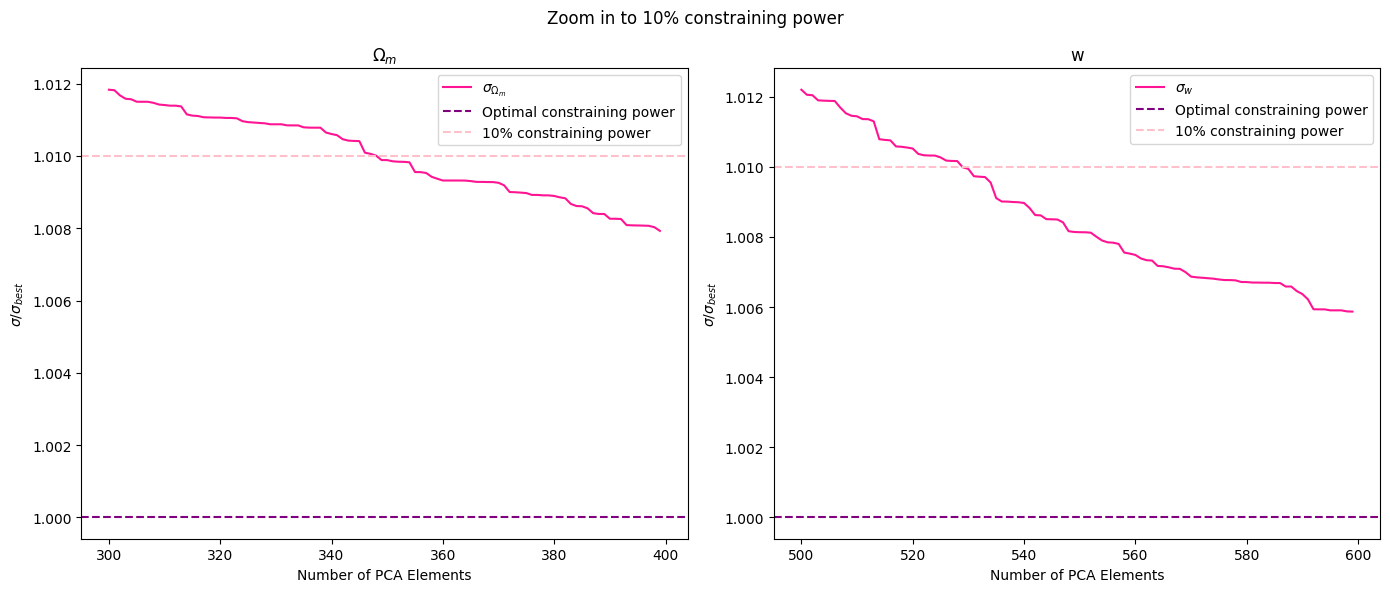

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Zoom in to 10% constraining power")

# Plot Omega_m constraints
axs[0].plot(np.arange(300, 400), paramter_constraints[298:398, 0]/Cov_parameter[0], color='#FF1493', linestyle='-', label = "$\sigma_{\Omega_m}$")
axs[0].set_xlabel('Number of PCA Elements')
axs[0].set_ylabel(r'$\sigma/\sigma_{best}$')
axs[0].set_title(r'$\Omega_m$')
axs[0].axhline(1, color='#800080', linestyle='--', label="Optimal constraining power")
#axs[0].axhline(1.1, color='orange', linestyle='--', label="1% constraining power")
axs[0].axhline(1.01, color='pink', linestyle='--', label="10% constraining power")
axs[0].legend()

# Plot w constraints
axs[1].plot(np.arange(500, 600), paramter_constraints[498:598, 1]/Cov_parameter[1], color='#FF1493', linestyle='-', label = "$\sigma_{w}$")
axs[1].set_xlabel('Number of PCA Elements')
axs[1].set_ylabel(r'$\sigma/\sigma_{best}$')
axs[1].set_title('w')
axs[1].axhline(1, color='#800080', linestyle='--', label="Optimal constraining power")
#axs[1].axhline(1.1, color='orange', linestyle='--', label="1% constraining power")
axs[1].axhline(1.01, color='pink', linestyle='--', label="10% constraining power")
axs[1].legend()

plt.tight_layout()
plt.show()

For what concerns $\Omega_m$, the 10% constraining power is reached with $\approx 340$ PCA elements. In the w case, the same constraining power is reached with $\approx 530$ elements.
